<a href="https://colab.research.google.com/github/Abubakrhegazi/Arabic-Grammar-AutoCorrection/blob/main/Semantic_Error_Detection_Edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Handling .m2 Datasets

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import math
import re

In [53]:
#functions dictionary
def smart_open(fname, mode = 'r'):
    if fname.endswith('.gz'):
        import gzip
        # Using max compression (9) by default seems to be slow.
        # Let's try using the fastest.
        return gzip.open(fname, mode, 1)
    else:
        return open(fname, mode)

def tokanizer(list):
  tokens =[]
  for s in list:
      for i in s:
          tokens.append(i.split(' '))
  return tokens

def randint(b, a=0):
    return random.randint(a,b)

def uniq(seq, idfun=None):
    # order preserving
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        # in old Python versions:
        # if seen.has_key(marker)
        # but in new ones:
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result

def sort_dict(myDict, byValue=False, reverse=False):
    if byValue:
        items = myDict.items()
        items.sort(key = operator.itemgetter(1), reverse=reverse)
    else:
        items = sorted(myDict.items())
    return items

def max_dict(myDict, byValue=False):
    if byValue:
        skey=lambda x:x[1]
    else:
        skey=lambda x:x[0]
    return max(myDict.items(), key=skey)


def min_dict(myDict, byValue=False):
    if byValue:
        skey=lambda x:x[1]
    else:
        skey=lambda x:x[0]
    return min(myDict.items(), key=skey)

def paragraphs(lines, is_separator=lambda x : x == '\n', joiner=''.join):
    paragraph = []
    for line in lines:
        if is_separator(line):
            if paragraph:
                yield joiner(paragraph)
                paragraph = []
        else:
            paragraph.append(line)
    if paragraph:
        yield joiner(paragraph)

def isASCII(word):
    try:
        word = word.decode("ascii")
        return True
    except UnicodeEncodeError :
        return False
    except UnicodeDecodeError:
        return False


def intersect(x, y):
    return [z for z in x if z in y]

# Mapping Windows CP1252 Gremlins to Unicode
# from http://effbot.org/zone/unicode-gremlins.htm
cp1252 = {
    # from http://www.microsoft.com/typography/unicode/1252.htm
    u"\x80": u"\u20AC", # EURO SIGN
    u"\x82": u"\u201A", # SINGLE LOW-9 QUOTATION MARK
    u"\x83": u"\u0192", # LATIN SMALL LETTER F WITH HOOK
    u"\x84": u"\u201E", # DOUBLE LOW-9 QUOTATION MARK
    u"\x85": u"\u2026", # HORIZONTAL ELLIPSIS
    u"\x86": u"\u2020", # DAGGER
    u"\x87": u"\u2021", # DOUBLE DAGGER
    u"\x88": u"\u02C6", # MODIFIER LETTER CIRCUMFLEX ACCENT
    u"\x89": u"\u2030", # PER MILLE SIGN
    u"\x8A": u"\u0160", # LATIN CAPITAL LETTER S WITH CARON
    u"\x8B": u"\u2039", # SINGLE LEFT-POINTING ANGLE QUOTATION MARK
    u"\x8C": u"\u0152", # LATIN CAPITAL LIGATURE OE
    u"\x8E": u"\u017D", # LATIN CAPITAL LETTER Z WITH CARON
    u"\x91": u"\u2018", # LEFT SINGLE QUOTATION MARK
    u"\x92": u"\u2019", # RIGHT SINGLE QUOTATION MARK
    u"\x93": u"\u201C", # LEFT DOUBLE QUOTATION MARK
    u"\x94": u"\u201D", # RIGHT DOUBLE QUOTATION MARK
    u"\x95": u"\u2022", # BULLET
    u"\x96": u"\u2013", # EN DASH
    u"\x97": u"\u2014", # EM DASH
    u"\x98": u"\u02DC", # SMALL TILDE
    u"\x99": u"\u2122", # TRADE MARK SIGN
    u"\x9A": u"\u0161", # LATIN SMALL LETTER S WITH CARON
    u"\x9B": u"\u203A", # SINGLE RIGHT-POINTING ANGLE QUOTATION MARK
    u"\x9C": u"\u0153", # LATIN SMALL LIGATURE OE
    u"\x9E": u"\u017E", # LATIN SMALL LETTER Z WITH CARON
    u"\x9F": u"\u0178", # LATIN CAPITAL LETTER Y WITH DIAERESIS
}

def fix_cp1252codes(text):
    # map cp1252 gremlins to real unicode characters
    if re.search(u"[\x80-\x9f]", text):
        def fixup(m):
            s = m.group(0)
            return cp1252.get(s, s)
        if isinstance(text, type("")):
            # make sure we have a unicode string
            text = unicode(text, "iso-8859-1")
        text = re.sub(u"[\x80-\x9f]", fixup, text)
    return text

def clean_utf8(text):
    return filter(lambda x : x > '\x1f' and x < '\x7f', text)

def pairs(iterable, overlapping=False):
    iterator = iterable.__iter__()
    token = iterator.next()
    i = 0
    for lookahead in iterator:
        if overlapping or i % 2 == 0:
            yield (token, lookahead)
        token = lookahead
        i += 1
    if i % 2 == 0:
        yield (token, None)

def frange(start, end=None, inc=None):
    "A range function, that does accept float increments..."

    if end == None:
        end = start + 0.0
        start = 0.0

    if inc == None:
        inc = 1.0

    L = []
    while 1:
        next = start + len(L) * inc
        if inc > 0 and next >= end:
            break
        elif inc < 0 and next <= end:
            break
        L.append(next)

    return L

def softmax(values):
    a = max(values)
    Z = 0.0
    for v in values:
        Z += math.exp(v - a)
    sm = [math.exp(v-a) / Z for v in values]
    return sm

In [54]:
import sys
from getopt import getopt

def load_annotation(gold_file):
    source_sentences = []
    gold_edits = []
    fgold = smart_open(gold_file, 'r')
    puffer = fgold.read()
    fgold.close()
    #puffer = puffer.decode('utf8')
    for item in paragraphs(puffer.splitlines(True)):
        item = item.splitlines(False)
        sentence = [line[2:].strip() for line in item if line.startswith('S ')]
        assert sentence != []
        annotations = {}
        for line in item[1:]:
            if line.startswith('I ') or line.startswith('S '):
                continue
            assert line.startswith('A ')
            line = line[2:]
            fields = line.split('|||')
            start_offset = int(fields[0].split()[0])
            end_offset = int(fields[0].split()[1])
            etype = fields[1]
            if etype == 'noop':
                start_offset = -1
                end_offset = -1
            corrections =  [c.strip() if c != '-NONE-' else '' for c in fields[2].split('||')]
            # NOTE: start and end are *token* offsets
            original = ' '.join(' '.join(sentence).split()[start_offset:end_offset])
            if len(fields) > 4:
                annotator = int(fields[5])
            else:
                annotator = 0  # default if missing
            if annotator not in annotations:
                annotations[annotator] = []
            annotations[annotator].append((start_offset, end_offset, original, corrections, etype))

        tok_offset = 0
        for this_sentence in sentence:
            tok_offset += len(this_sentence.split())
            source_sentences.append(this_sentence)
            this_edits = {}
            for annotator, annotation in annotations.items():
                this_edits[annotator] = [edit for edit in annotation if edit[0] <= tok_offset and edit[1] <= tok_offset and edit[0] >= 0 and edit[1] >= 0]
            if len(this_edits) == 0:
                this_edits[0] = []
            gold_edits.append(this_edits)
    return (source_sentences, gold_edits)

# **Train Data Preprocessing**

In [55]:
sentences=[]
edits=[]

sentences.append(load_annotation('/content/drive/MyDrive/Grammar/QALB-Train2014.m2')[0])
edits.append(load_annotation('/content/drive/MyDrive/Grammar/QALB-Train2014.m2')[1])


In [56]:
import pandas as pd

# Combine the lists of sentences and edits into a list of dictionaries
data_list = []
for sent_text, edit_dict in zip(sentences[0], edits[0]):
    data_list.append({'sentence': sent_text, 'edits': edit_dict})

# Create a DataFrame
df = pd.DataFrame(data_list)

# Function to apply edits and produce a corrected sentence
def apply_edits(sentence, edits_dict):
    tokens = sentence.split()

    if not edits_dict or 0 not in edits_dict:
        return sentence  # No edits

    edits = edits_dict[0]  # Use annotator 0
    for start, end, _, correction, _ in sorted(edits, key=lambda x: x[0], reverse=True):
        tokens = tokens[:start] + correction + tokens[end:]

    return ' '.join(tokens)


# Apply the edits
df['corrected'] = df.apply(lambda row: apply_edits(row['sentence'], row['edits']), axis=1)

# Optional: Filter out unchanged sentences
# df = df[df['sentence'] != df['corrected']]

# Print example
print(df[['sentence', 'corrected']].head())
print("\nDataFrame shape:", df.shape)


                                            sentence  \
0  الى التعليق رقم 2 اكيد ان لحكام العرب والمسلمي...   
1  نحن ببالغ الاسى نعزي ضحايا الحادث الاليم الذي ...   
2  للاسف ان الدم المهدور عراقي لكن بشكل عام لماذا...   
3  واصل الثوار أنتصاراتهم وحررو كل حقول النفط الس...   
4  يا حرام على ما يدعو نفسهم شبيحة الأسد وحزب الل...   

                                           corrected  
0  إلى التعليق رقم 2 أكيد اكيد أن للحكام العرب وا...  
1  نحن ببالغ الأسى نعزي ضحايا الحادث الأليم الذي ...  
2  للأسف إن الدم المهدور عراقي ، لكن بشكل عام لما...  
3  واصل الثوار انتصاراتهم وحرروا كل حقول النفط ال...  
4  يا حرام على من يدعون نفسهم شبيحة الأسد وحزب ال...  

DataFrame shape: (19411, 3)


In [57]:
df.head(11)

,sentence,edits,corrected
0,الى التعليق رقم 2 اكيد ان لحكام العرب والمسلمي...,"{0: [(0, 1, 'الى', ['إلى'], 'Edit'), (4, 4, ''...",إلى التعليق رقم 2 أكيد اكيد أن للحكام العرب وا...
1,نحن ببالغ الاسى نعزي ضحايا الحادث الاليم الذي ...,"{0: [(2, 3, 'الاسى', ['الأسى'], 'Edit'), (6, 7...",نحن ببالغ الأسى نعزي ضحايا الحادث الأليم الذي ...
2,للاسف ان الدم المهدور عراقي لكن بشكل عام لماذا...,"{0: [(0, 1, 'للاسف', ['للأسف'], 'Edit'), (1, 2...",للأسف إن الدم المهدور عراقي ، لكن بشكل عام لما...
3,واصل الثوار أنتصاراتهم وحررو كل حقول النفط الس...,"{0: [(2, 3, 'أنتصاراتهم', ['انتصاراتهم'], 'Edi...",واصل الثوار انتصاراتهم وحرروا كل حقول النفط ال...
4,يا حرام على ما يدعو نفسهم شبيحة الأسد وحزب الل...,"{0: [(3, 4, 'ما', ['من'], 'Edit'), (4, 5, 'يدع...",يا حرام على من يدعون نفسهم شبيحة الأسد وحزب ال...
5,اليوم المظاهرات الحاشدة تعتبر جمعة مفصلية تاري...,"{0: [(7, 7, '', ['،'], 'Add_before'), (10, 11,...",اليوم المظاهرات الحاشدة تعتبر جمعة مفصلية تاري...
6,وقف اطلاق الصواريخ من غزة مقابل رفع الحصار عن ...,"{0: [(1, 2, 'اطلاق', ['إطلاق'], 'Edit'), (12, ...",وقف إطلاق الصواريخ من غزة مقابل رفع الحصار عن ...
7,"إلى الإخوة في الجزيرة , هؤلاء شهداء وهم خيرة ا...","{0: [(4, 5, ',', [':'], 'Edit'), (7, 7, '', ['...",إلى الإخوة في الجزيرة : هؤلاء شهداء ، وهم خيرة...
8,مصير جميع الإرهابيين السحق على يد الجيش التركي...,"{0: [(8, 8, '', ['.'], 'Add_before'), (11, 12,...",مصير جميع الإرهابيين السحق على يد الجيش التركي...
9,ثورة الآخرين على ارض الشام حيث ان الجيش الحر ي...,"{0: [(3, 4, 'ارض', ['أرض'], 'Edit'), (5, 5, ''...",ثورة الآخرين على أرض الشام ، حيث أن الجيش الحر...


In [58]:
df = df.rename(columns={
    'sentence': 'input',
    'edits': 'edits',
    'corrected': 'target'
})
df['edit_count'] = df['edits'].apply(lambda e: len(e.get(0, [])))
df['edit_types'] = df['edits'].apply(
    lambda e: [et[4] for et in e.get(0, [])] if len(e.get(0, [])) > 0 and len(e.get(0, [])[0]) > 4 else []
)
df['edit_types'] = df['edits'].apply(lambda e: [et[4] for et in e.get(0, [])])

df.head()

,input,edits,target,edit_count,edit_types
0,الى التعليق رقم 2 اكيد ان لحكام العرب والمسلمي...,"{0: [(0, 1, 'الى', ['إلى'], 'Edit'), (4, 4, ''...",إلى التعليق رقم 2 أكيد اكيد أن للحكام العرب وا...,14,"[Edit, Add_before, Edit, Edit, Edit, Edit, Edi..."
1,نحن ببالغ الاسى نعزي ضحايا الحادث الاليم الذي ...,"{0: [(2, 3, 'الاسى', ['الأسى'], 'Edit'), (6, 7...",نحن ببالغ الأسى نعزي ضحايا الحادث الأليم الذي ...,16,"[Edit, Edit, Add_before, Edit, Edit, Add_befor..."
2,للاسف ان الدم المهدور عراقي لكن بشكل عام لماذا...,"{0: [(0, 1, 'للاسف', ['للأسف'], 'Edit'), (1, 2...",للأسف إن الدم المهدور عراقي ، لكن بشكل عام لما...,22,"[Edit, Edit, Add_before, Edit, Add_before, Add..."
3,واصل الثوار أنتصاراتهم وحررو كل حقول النفط الس...,"{0: [(2, 3, 'أنتصاراتهم', ['انتصاراتهم'], 'Edi...",واصل الثوار انتصاراتهم وحرروا كل حقول النفط ال...,7,"[Edit, Edit, Edit, Edit, Edit, Add_before, Edit]"
4,يا حرام على ما يدعو نفسهم شبيحة الأسد وحزب الل...,"{0: [(3, 4, 'ما', ['من'], 'Edit'), (4, 5, 'يدع...",يا حرام على من يدعون نفسهم شبيحة الأسد وحزب ال...,10,"[Edit, Edit, Edit, Edit, Add_before, Edit, Edi..."


In [59]:
from collections import Counter
Counter([et for row in df['edit_types'] for et in row]).most_common()


[('Edit', 169769),
 ('Add_before', 99258),
 ('Merge', 18267),
 ('Split', 10675),
 ('Delete', 6778),
 ('Other', 1563),
 ('Move', 427),
 ('Add_after', 20)]

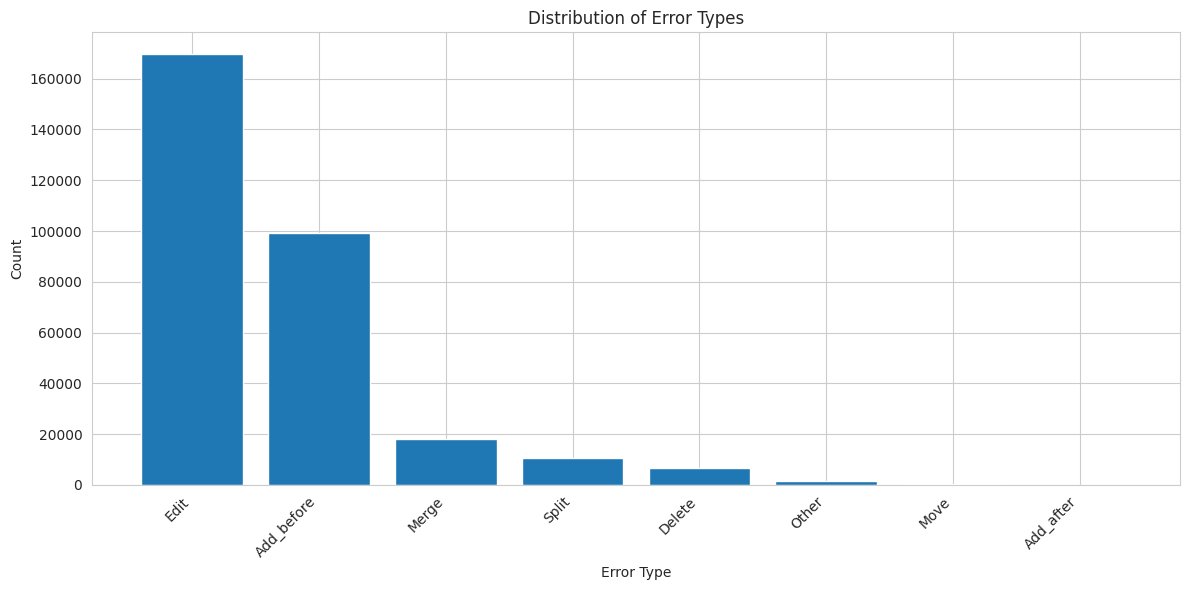

In [60]:
# Get the error type counts
error_counts = Counter([et for row in df['edit_types'] for et in row]).most_common()

# Extract labels and values for plotting
labels = [item[0] for item in error_counts]
values = [item[1] for item in error_counts]

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.title('Distribution of Error Types')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

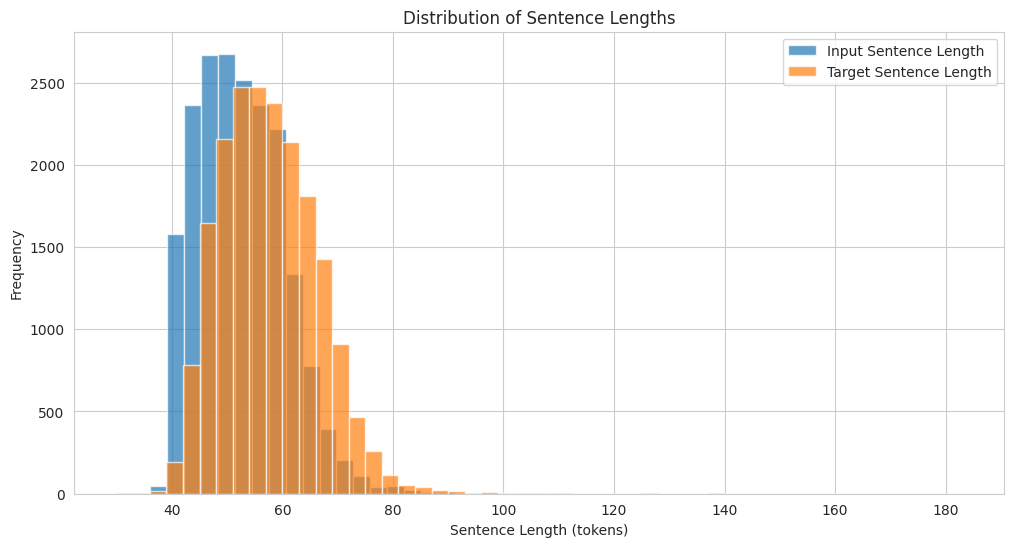

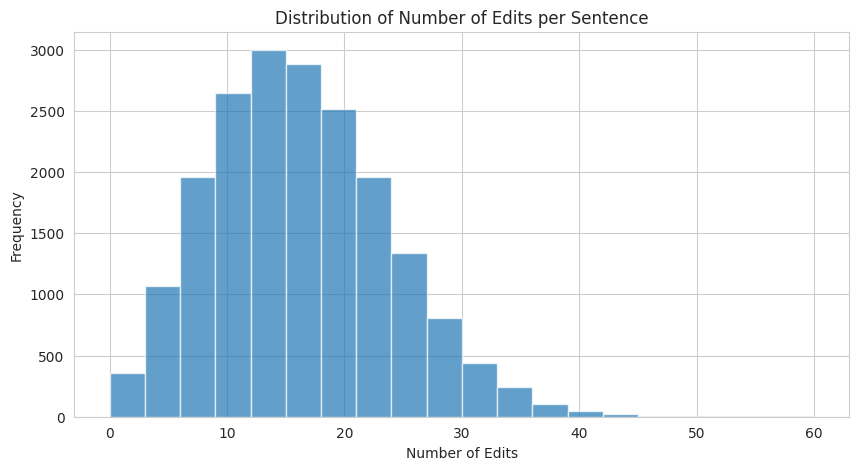

In [61]:
# Calculate sentence lengths
df['input_length'] = df['input'].apply(lambda x: len(x.split()))
df['target_length'] = df['target'].apply(lambda x: len(x.split()))

# Plot distribution of sentence lengths
plt.figure(figsize=(12, 6))
plt.hist(df['input_length'], bins=50, alpha=0.7, label='Input Sentence Length')
plt.hist(df['target_length'], bins=50, alpha=0.7, label='Target Sentence Length')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.legend()
plt.show()

# Plot distribution of the number of edits per sentence
plt.figure(figsize=(10, 5))
plt.hist(df['edit_count'], bins=20, alpha=0.7)
plt.xlabel('Number of Edits')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Edits per Sentence')
plt.show()

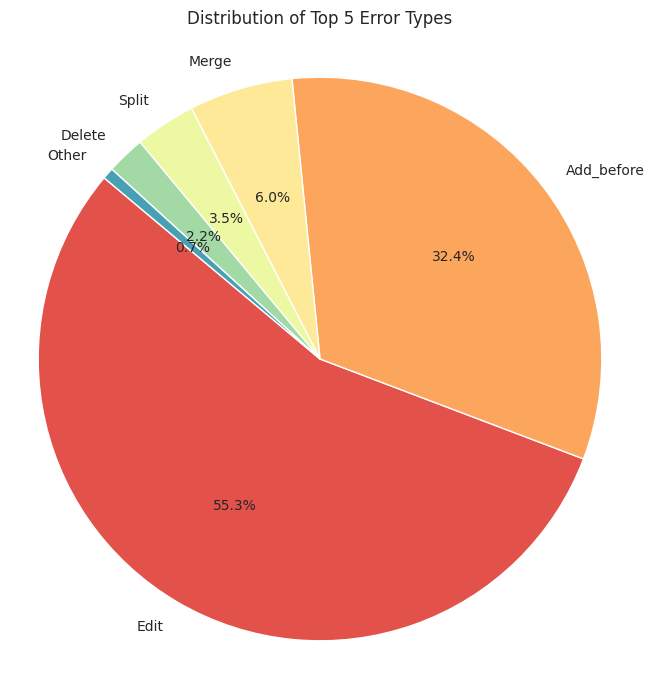

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns # Often provides nicer default styles and palettes

# Ensure seaborn is installed
try:
    import seaborn as sns
except ImportError:
    !pip install seaborn -q
    import seaborn as sns

# Get the top 5 error types
top_n = 5
top_error_counts = Counter([et for row in df['edit_types'] for et in row]).most_common(top_n)

# Calculate the counts for 'Other' errors
other_count = sum([count for error_type, count in Counter([et for row in df['edit_types'] for et in row]).items() if error_type not in [item[0] for item in top_error_counts]])

# Prepare data for the pie chart
labels = [item[0] for item in top_error_counts]
sizes = [item[1] for item in top_error_counts]

# Add 'Other' if there are more than top_n types
if other_count > 0:
    labels.append('Other')
    sizes.append(other_count)

# Set a nice style
sns.set_style("whitegrid")

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Spectral', len(labels)))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Top 5 Error Types', pad=20) # Add some padding to the title
plt.show()


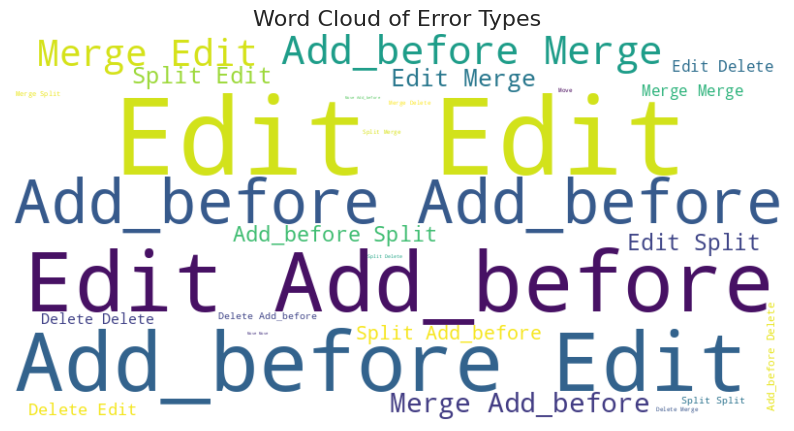

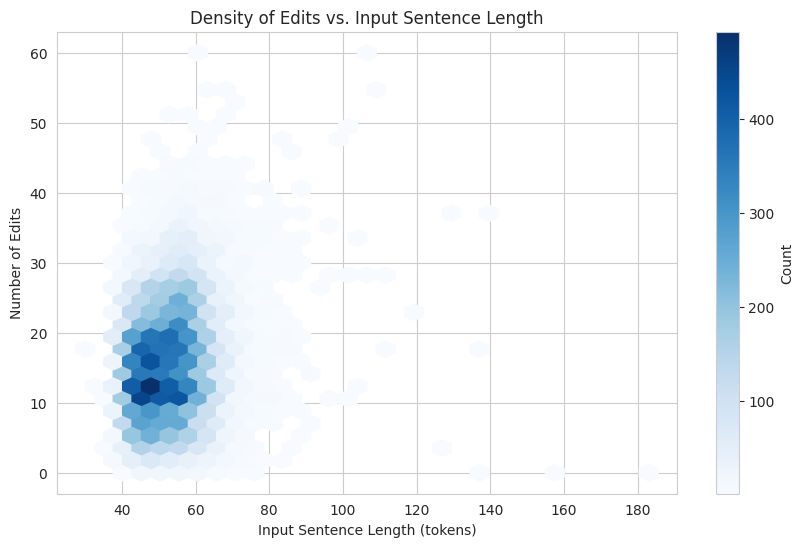

<ipython-input-63-5c96f354b2ba>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='input_length_bucket', y='edit_count', data=df_vis, inner='quartile', palette='viridis')


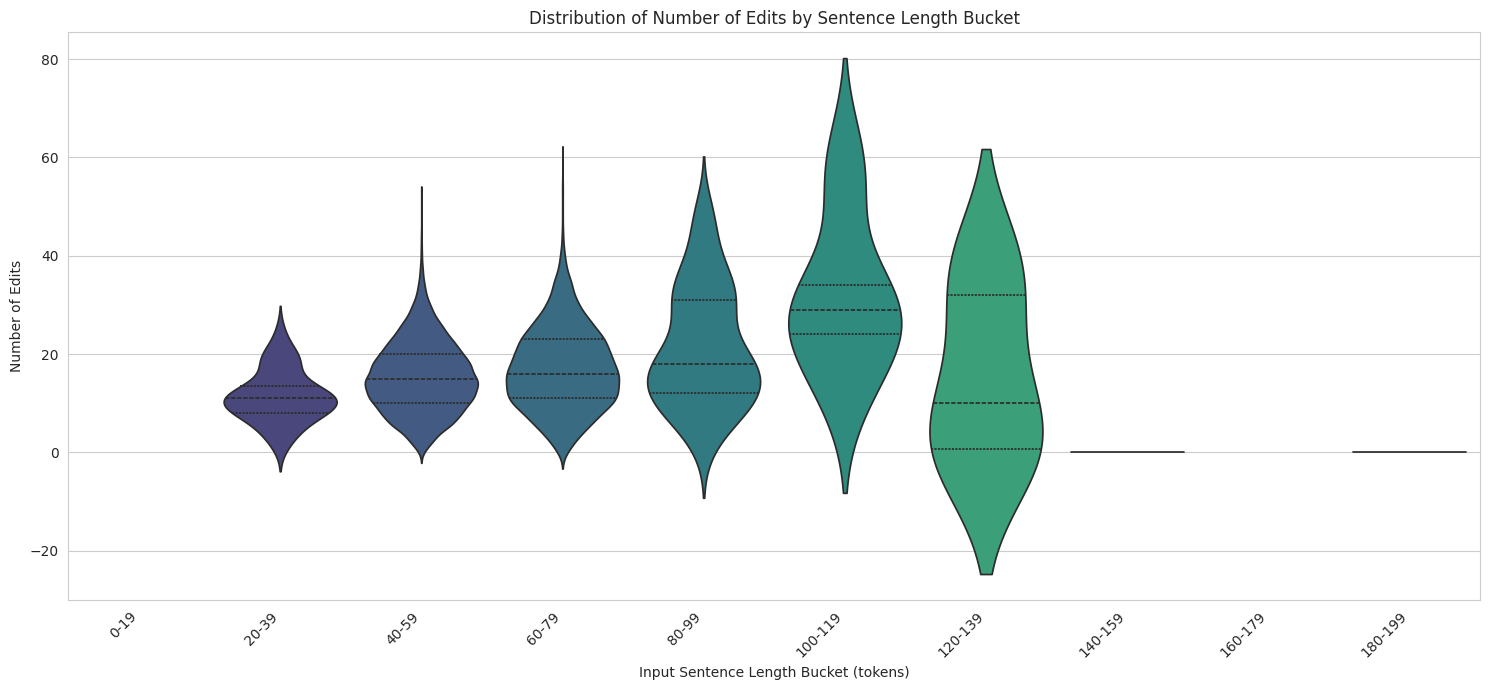

<ipython-input-63-5c96f354b2ba>:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_type_by_bucket = df_exploded_errors.groupby(['input_length_bucket', 'top_error_types']).size().unstack(fill_value=0)


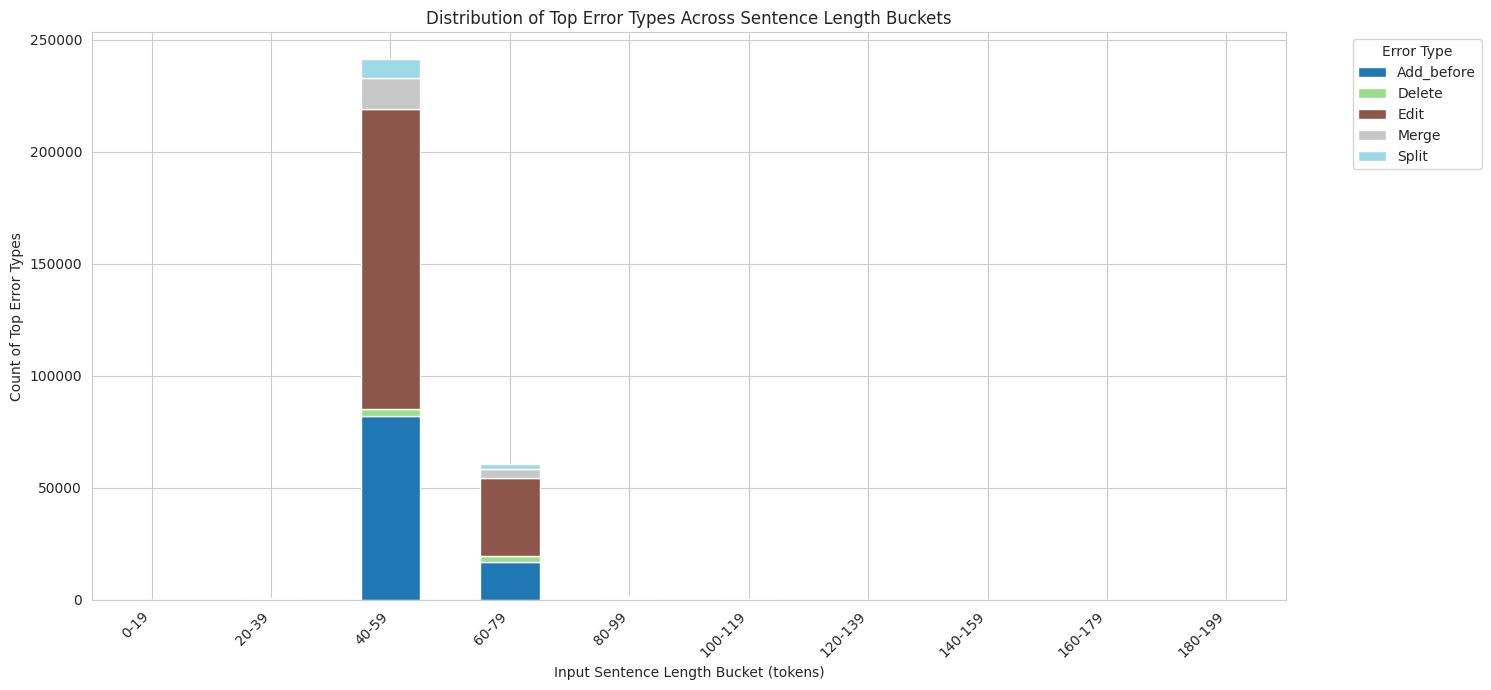

In [63]:
# Creative Visualization: Word Cloud of Most Frequent Error Types

# Ensure wordcloud is installed
try:
    from wordcloud import WordCloud
except ImportError:
    !pip install wordcloud -q
    from wordcloud import WordCloud

# Get all error types from the dataframe
all_error_types = [et for row in df['edit_types'] for et in row]

# Create a single string of all error types, separated by spaces
error_types_text = " ".join(all_error_types)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(error_types_text)

# Display the generated image
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Error Types', fontsize=16)
plt.show()

# Creative Visualization: Relationship between Sentence Length and Number of Edits (Scatter Plot with Hexbin)

# Use hexbin for better visualization of density
plt.figure(figsize=(10, 6))
hb = plt.hexbin(df['input_length'], df['edit_count'], gridsize=30, cmap='Blues', mincnt=1)
plt.colorbar(hb, label='Count')
plt.xlabel('Input Sentence Length (tokens)')
plt.ylabel('Number of Edits')
plt.title('Density of Edits vs. Input Sentence Length')
plt.show()

# Creative Visualization: Violin Plot of Number of Edits by Sentence Length Buckets

# Create buckets for sentence length
df['input_length_bucket'] = pd.cut(df['input_length'], bins=np.arange(0, df['input_length'].max() + 20, 20), right=False, labels=[f'{i}-{i+19}' for i in np.arange(0, df['input_length'].max(), 20)])

# Drop rows where bucket couldn't be assigned (e.g., very long sentences exceeding the last bucket)
df_vis = df.dropna(subset=['input_length_bucket'])

# Ensure there are enough data points in each bucket for a violin plot
if len(df_vis) > 0 and df_vis['input_length_bucket'].nunique() > 1:
    plt.figure(figsize=(15, 7))
    sns.violinplot(x='input_length_bucket', y='edit_count', data=df_vis, inner='quartile', palette='viridis')
    plt.xlabel('Input Sentence Length Bucket (tokens)')
    plt.ylabel('Number of Edits')
    plt.title('Distribution of Number of Edits by Sentence Length Bucket')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough variation in sentence lengths to create a meaningful violin plot by buckets.")


# Creative Visualization: Stacked Bar Chart of Top Error Types by Sentence Length Buckets (if meaningful)

# Get the top N error types again (excluding 'noop' if not desired for this analysis)
top_n_errors = Counter([et for row in df['edit_types'] for et in row if et != 'noop']).most_common(5)
top_error_list = [item[0] for item in top_n_errors]

# Filter dataframe to include only top error types
df_top_errors = df_vis.copy() # Use the dataframe with length buckets
df_top_errors['top_error_types'] = df_top_errors['edit_types'].apply(lambda error_list: [e for e in error_list if e in top_error_list])

# Explode the list of errors into multiple rows for easier counting
df_exploded_errors = df_top_errors.explode('top_error_types')

# Count occurrences of each top error type within each length bucket
error_type_by_bucket = df_exploded_errors.groupby(['input_length_bucket', 'top_error_types']).size().unstack(fill_value=0)

# Plot the stacked bar chart
if not error_type_by_bucket.empty:
    error_type_by_bucket.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='tab20')
    plt.xlabel('Input Sentence Length Bucket (tokens)')
    plt.ylabel('Count of Top Error Types')
    plt.title('Distribution of Top Error Types Across Sentence Length Buckets')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data or top error types to create a stacked bar chart by sentence length buckets.")



In [64]:
df_copy = df.copy()

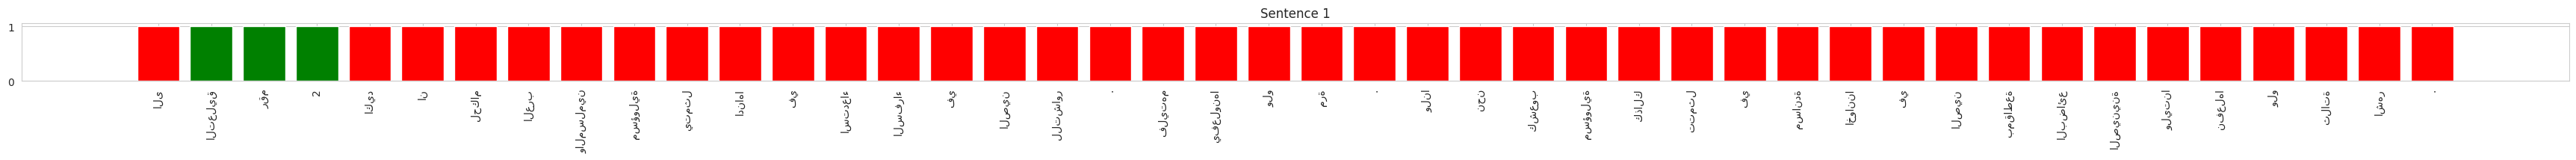

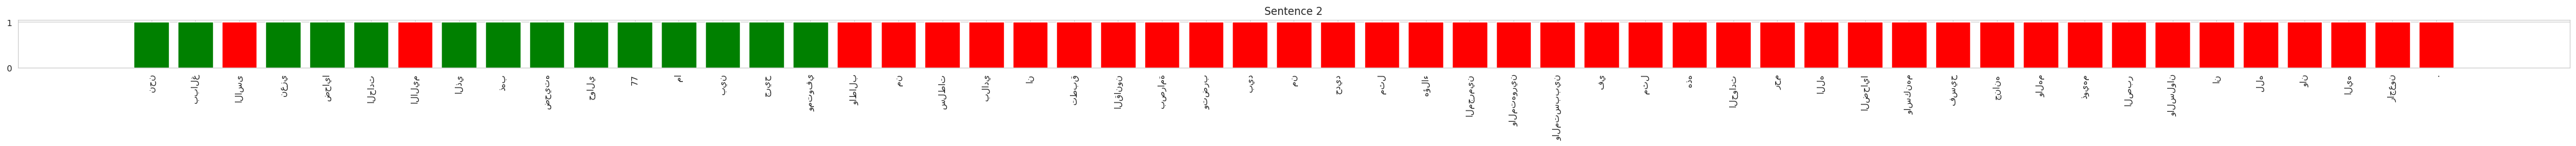

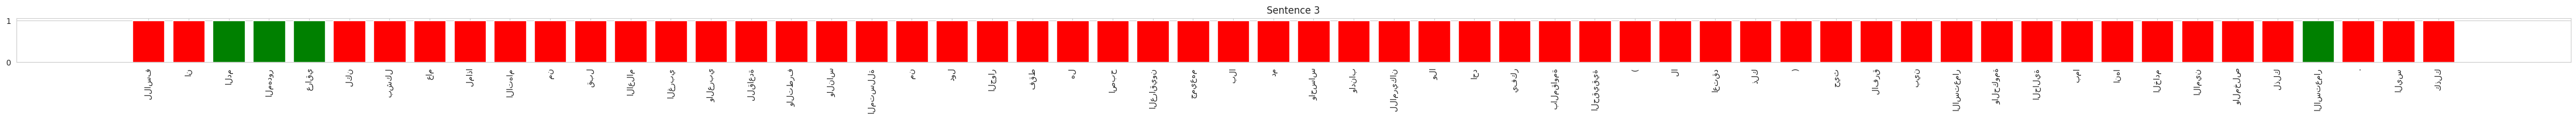

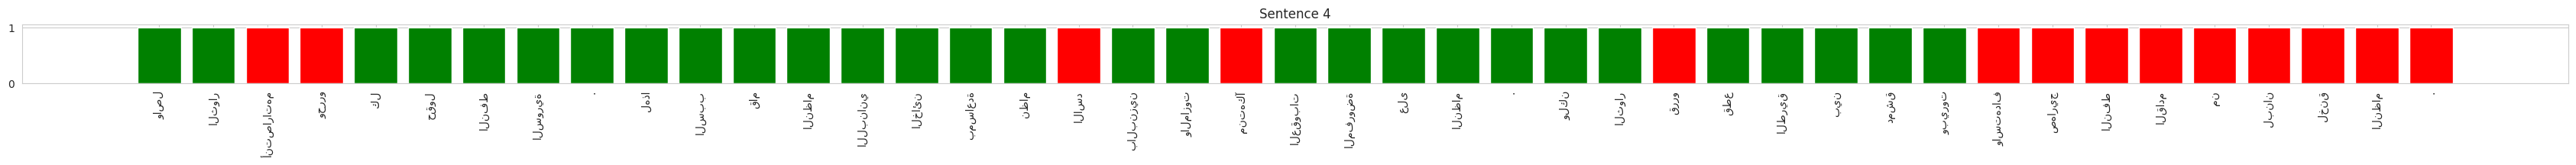

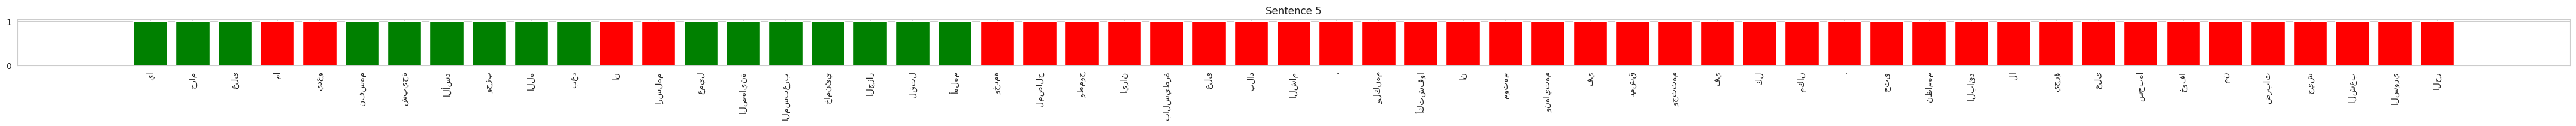

In [65]:
# simplified version
import matplotlib.pyplot as plt

for idx, row in df_copy.head(5).iterrows():
    words = row['input'].split()
    correct = row['target'].split()
    colors = ['red' if w1 != w2 else 'green' for w1, w2 in zip(words, correct)]
    plt.figure(figsize=(len(words), 1))
    plt.bar(range(len(words)), [1]*len(words), color=colors)
    plt.xticks(range(len(words)), words, rotation=90)
    plt.title(f"Sentence {idx+1}")
    plt.show()


In [66]:
#delete first 13k row

# df = df.iloc[13000:]

In [67]:
df = df.sort_values(by='edit_count', ascending=True)

In [68]:
df_model = df[['input', 'target']]

In [69]:
import re

import re

def clean_text(sent):
    # Remove Latin letters
    sent = re.sub(r'[a-zA-Z]', '', sent)

    # Remove symbols, math, formatting, and Western punctuation EXCEPT Arabic ones
    sent = re.sub(r'[ـ\-\(\)\*/&_%؛@ٱ٪\[\]=^{}\\$`~|\'\"\n\r\t]', '', sent)

    # Remove diacritics (Tashkeel)
    sent = re.sub(r'[ًٌٍُِّْ]', '', sent)

    # Normalize space (optional)
    sent = re.sub(r'\s+', ' ', sent).strip()

    return sent

df_model['input'] = df_model['input'].apply(clean_text)
df_model['target'] = df_model['target'].apply(clean_text)
df = df_model

<ipython-input-69-94c874a4c51a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['input'] = df_model['input'].apply(clean_text)
<ipython-input-69-94c874a4c51a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['target'] = df_model['target'].apply(clean_text)


In [70]:

# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")

# encoding = tokenizer("هاذا الجمله فيهه خطاء.", max_length=128, padding='max_length', truncation=True)


In [71]:
def preprocess(example):
    model_input = tokenizer(
        example['input'],
        max_length=128,
        padding='max_length',
        truncation=True
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example['target'],
            max_length=128,
            padding='max_length',
            truncation=True
        )
    model_input['labels'] = labels['input_ids']
    return model_input


In [72]:

import torch
print(torch.__version__)


2.5.1+cu124


In [73]:
import torch
print(torch.cuda.is_available())         # Should return True
print(torch.cuda.get_device_name(0))     # Shows your current GPU (e.g., T4, V100)


True
NVIDIA A100-SXM4-40GB


#Check for class imbalance



In [74]:
df['label'] = (df['input'] != df['target']).astype(int)

<ipython-input-74-e8369d2d7138>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = (df['input'] != df['target']).astype(int)


In [75]:
df.head(10)

,input,target,label
14934,قصيدة جميلة بمنتهى الكلمة والمعنى وأكد أن الشع...,قصيدة جميلة بمنتهى الكلمة والمعنى وأكد أن الشع...,0
8185,وأما ما ينفع الناس فيمكث في الأرض كذلك يضرب ال...,وأما ما ينفع الناس فيمكث في الأرض كذلك يضرب ال...,0
11911,الرسالة واضحة السودان مستهدف أرضا وشعبا قيما و...,الرسالة واضحة السودان مستهدف أرضا وشعبا قيما و...,0
2730,اللهم احشر كل من دافع عن بشار الأسد معه . . ال...,اللهم احشر كل من دافع عن بشار الأسد معه . . ال...,0
15832,مشكلة الأحزاب الإسلامية هي غياب الحوار الحر وت...,مشكلة الأحزاب الإسلامية هي غياب الحوار الحر وت...,0
6557,المدعو قنديل يهددنا بحزب حسن وكأنهم كائنات خار...,المدعو قنديل يهددنا بحزب حسن وكأنهم كائنات خار...,0
13713,الكاتب أبدع في توضيح حقيقة الدولة المدنية التي...,الكاتب أبدع في توضيح حقيقة الدولة المدنية التي...,0
8574,أتمنى على الجزيرة نت أن تفحص التعليقات التي تر...,أتمنى على الجزيرة نت أن تفحص التعليقات التي تر...,0
10149,على جميع الحكام العرب أن يعوا الدرس جيدا ، فقم...,على جميع الحكام العرب أن يعوا الدرس جيدا ، فقم...,0
10445,أحب أن أوضح أن جيفارا ألحد بالكنيسة كما فعل كث...,أحب أن أوضح أن جيفارا ألحد بالكنيسة كما فعل كث...,0


In [76]:
# Frequency
print(df['label'].value_counts())

# Percentages
print(df['label'].value_counts(normalize=True) * 100)


label
1    19359
0       52
Name: count, dtype: int64
label
1    99.732111
0     0.267889
Name: proportion, dtype: float64


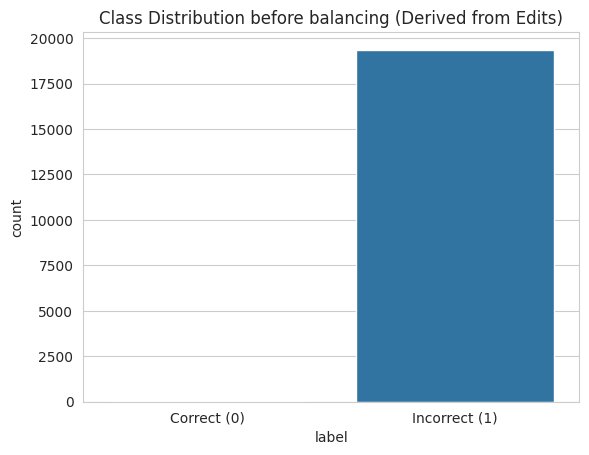

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.xticks([0, 1], ['Correct (0)', 'Incorrect (1)'])
plt.title('Class Distribution before balancing (Derived from Edits)')
plt.show()


In [78]:
df.shape

(19411, 3)

In [79]:
n = 9500 #Size that will be divided for each class

In [80]:
# Sample 2500 incorrect ones
incorrect_samples = df[df['input'] != df['target']].sample(n=2500, random_state=42)

# Sample 2500 manually corrected sentences
correct_samples = df.sample(n=2500, random_state=42).copy()

In [81]:
df_correct = correct_samples.copy()
df_correct['label'] = 0
df_correct['input'] = df_correct['target']

df_incorrect = incorrect_samples.copy()
df_incorrect['label'] = 1

df_balanced = pd.concat([df_correct, df_incorrect]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['label'].value_counts())
# Should return 2500 for each class


label
0    2500
1    2500
Name: count, dtype: int64


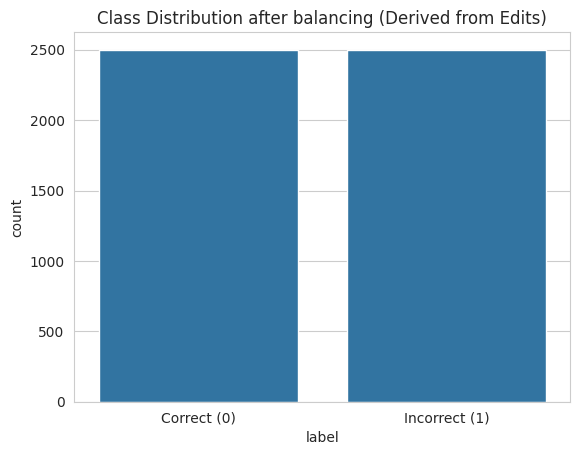

In [82]:
sns.countplot(x='label', data=df_balanced)
plt.xticks([0, 1], ['Correct (0)', 'Incorrect (1)'])
plt.title('Class Distribution after balancing (Derived from Edits)')
plt.show()

In [83]:
df_balanced = pd.concat([df_correct, df_incorrect]).sample(frac=1, random_state=42).reset_index(drop=True)

In [84]:
print(df_balanced['label'].value_counts())

label
0    2500
1    2500
Name: count, dtype: int64


# LSTM

In [109]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.optimizers import RMSprop

latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(None,), name="encoder_input")
enc_emb = Embedding(vocab_size, latent_dim)(encoder_inputs)  # remove mask_zero=True
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,), name="decoder_input")
dec_emb = Embedding(vocab_size, latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Attention
attention = Attention()  # Basic dot-product attention
attention_output = attention([decoder_outputs, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Output layer
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs_final = decoder_dense(decoder_combined_context)

# Compile
model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, None, 256)      │         20,736 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, None, 256)      │         20,736 │ decoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ [(None, None, 256),    │        525,312 │ embedding_8[0][0]      │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ [(None, None, 256),    │        525,312 │ embedding_9[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_8[0][1],          │
│                           │ 256)]                  │                │ lstm_8[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_3 (Attention)   │ (None, None, 256)      │              0 │ lstm_9[0][0],          │
│                           │                        │                │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, None, 512)      │              0 │ lstm_9[0][0],          │
│ (Concatenate)             │                        │                │ attention_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, None, 81)       │         41,553 │ concatenate_5[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,133,649 (4.32 MB)

 Trainable params: 1,133,649 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,           # 2-D int matrix
    batch_size=128,
    epochs=20,
    validation_split=0.1,
    callbacks=[early_stop]         # if you added EarlyStopping
)

Epoch 1/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.6283 - loss: 1.5379 - val_accuracy: 0.6508 - val_loss: 1.3523
Epoch 2/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.6998 - loss: 1.1511 - val_accuracy: 0.6637 - val_loss: 1.2589
Epoch 3/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.7095 - loss: 1.0825 - val_accuracy: 0.6698 - val_loss: 1.2103
Epoch 4/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7177 - loss: 1.0408 - val_accuracy: 0.6791 - val_loss: 1.1824
Epoch 5/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7242 - loss: 1.0091 - val_accuracy: 0.6873 - val_loss: 1.1429
Epoch 6/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7313 - loss: 0.9821 - val_accuracy: 0.6927 - val_loss: 1.1231
Epoch 7/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7370 - loss: 0.9594 - val_accuracy: 0.6986 - val_loss: 1.0954
Epoch 8/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7419 - loss: 0.9389 - val_acc

In [90]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

ref = ['هذا', 'نص', 'صحيح']
pred = ['هاذا', 'نص', 'صحيح']

smooth = SmoothingFunction().method4  # or method1, method2...
score = sentence_bleu([ref], pred, smoothing_function=smooth)

print("BLEU Score:", round(score, 4))


BLEU Score: 0.2118


In [91]:
# model.save('arabic_grammar_corrector.h5')

# Optional Evaluation
score = model.evaluate([encoder_input_data, decoder_input_data], decoder_target_onehot)
print("Validation loss:", score[0])
print("Validation accuracy:", score[1])


607/607 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.1654 - loss: 0.9214
Validation loss: 0.9603019952774048
Validation accuracy: 0.17135316133499146


## Testing LSTM

In [ ]:
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])


In [ ]:
# New inputs for states
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
encoder_output_input = Input(shape=(None, latent_dim))  # for attention

# Decoder embedding
dec_emb2 = Embedding(vocab_size, latent_dim)(decoder_inputs)

# Decoder LSTM with initial state
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention
attention_output2 = attention([decoder_outputs2, encoder_output_input])
decoder_combined_context2 = Concatenate(axis=-1)([decoder_outputs2, attention_output2])

# Final output
decoder_outputs2_final = decoder_dense(decoder_combined_context2)

# Decoder model
decoder_model = Model(
    [decoder_inputs, encoder_output_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2_final, state_h2, state_c2]
)


In [ ]:
def decode_sequence(input_seq, tokenizer, max_decoder_seq_length):
    # Encode input and get states
    enc_outs, h, c = encoder_model.predict(input_seq)

    # Start token '\t'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['\t']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, enc_outs, h, c])

        # Pick token with max prob
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = tokenizer.index_word.get(sampled_token_index, '')

        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        else:
            decoded_sentence += sampled_char

        # Update target_seq to sampled_token
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return decoded_sentence


In [ ]:
# Prepare test sentence
test_sentence = "هاذا الجمله فيهه خطاء."
seq = tokenizer.texts_to_sequences([test_sentence])
seq = pad_sequences(seq, maxlen=max_encoder_seq_length, padding='post')

# Predict
corrected = decode_sequence(seq, tokenizer, max_decoder_seq_length)
print("❌ Input:", test_sentence)
print("✅ Corrected:", corrected)
